<a href="https://colab.research.google.com/github/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/notebooks/Week_2/Week_2_Lecture_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 3: Scale Space, Image Pyramids and Filter Banks

In [5]:
#@title 
from ipywidgets import widgets
out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"f4mL4Thr9hc", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)
display(out1)

Output()

In [6]:
#@title 
from IPython import display as IPyDisplay
IPyDisplay.HTML(
    f"""
  <div>
    <a href= "https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Slides/Week_2/DL4CV_Week02_Part03.pdf" target="_blank">
    <img src="https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Data/Slides_Logo.png?raw=1"
  alt="button link to Airtable" style="width:200px"></a>
    </div>""" )

## GENERATE SINUSOID STIMULI

I(x) = A*$\cos$(wx+p)

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np


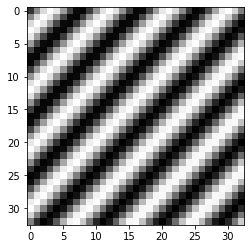

In [8]:
def Generate_Sinusoid(size_of_image, A, omega, rho):
    """
    Generating sinusoid grating 
    A : amplitude
    rho : phase
    omega : frequency
    size_of_image : (height, width)
    """

    radius = (int(size_of_image[0]/2.0), int(size_of_image[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    I = A * np.cos(omega[0] * x  + omega[1] * y + rho)
    return I

theta = np.pi/4
omega = [np.cos(theta), np.sin(theta)]
sinusoidParam = {'A':1, 'omega':omega, 'rho':np.pi/2, 'size_of_image':(32,32)}
imshow(Generate_Sinusoid(**sinusoidParam), cmap='gray') 
# ** is a special syntax in python, which enables passing a key-value dictionary as parameter

## Generate-gabor-filter
A general type of Gabor filter[1] can be defined:<br>
$$ g(x,y;\lambda,\theta,\psi,\sigma,\gamma) = \exp\left(-\frac{x'^2+\gamma^2y'^2}{2\sigma^2}\right)\exp\left(i\left(2\pi\frac{x'}{\lambda}+\psi\right)\right) $$
[1] <a href="https://en.wikipedia.org/wiki/Gabor_filter">https://en.wikipedia.org/wiki/Gabor_filter</a></p>

Here we implement a type of Gabor filter which satisfies the neurophysiological constraints for simple cells:<br>
$$ \psi (x; \omega, \theta, K) = \left[\frac{\omega^2}{ 4 \pi K^2} \exp  \{-(\omega^2/8K^2)[4(x\cdot(cos\theta, sin\theta))^2 + (x \cdot ( -sin \theta, cos \theta))^2]\} \right] \times \left[ \exp \{ iwx \cdot (cos\theta, sin\theta) \} exp(K^2/2) \right] $$</p>

</div>

1.5140274644582012e-05

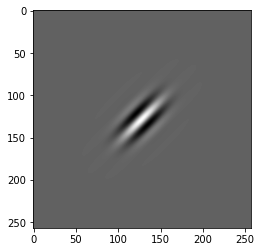

In [9]:

def genGabor(size_of_image, omega, theta, func=np.cos, K=np.pi):
    radius = (int(size_of_image[0]/2.0), int(size_of_image[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)
    
    gauss = omega**2 / (4*np.pi * K**2) * np.exp(- omega**2 / (8*K**2) * ( 4 * x1**2 + y1**2))
    sinusoid = func(omega * x1) * np.exp(K**2 / 2)
    gabor = gauss * sinusoid
    return gabor
        
g = genGabor((256,256), 0.3, np.pi/4, func=np.cos) 
# change func to "cos", "sin" can generate sin gabor or cos gabor, here we pass a function name as a parameter
imshow(g, cmap='gray')
np.mean(g)

# Generate gabor filter bank

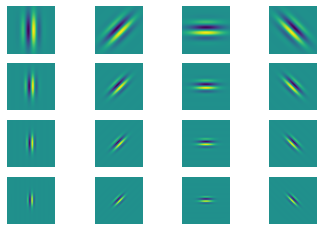

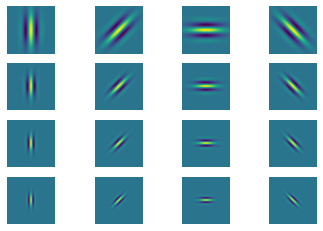

In [10]:
theta = np.arange(0, np.pi, np.pi/4) # range of theta
omega = np.arange(0.2, 0.6, 0.1) # range of omega
params = [(t,o) for o in omega for t in theta]
sinFilterBank = []
cosFilterBank = []
gaborParams = []
for (theta, omega) in params:
    gaborParam = {'omega':omega, 'theta':theta, 'size_of_image':(128, 128)}
    sinGabor = genGabor(func=np.sin, **gaborParam)
    cosGabor = genGabor(func=np.cos, **gaborParam)
    sinFilterBank.append(sinGabor)
    cosFilterBank.append(cosGabor)
    gaborParams.append(gaborParam)

plt.figure()
n = len(sinFilterBank)
for i in range(n):
    plt.subplot(4,4,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(sinFilterBank[i])

plt.figure()
for i in range(n):
    plt.subplot(4,4,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(cosFilterBank[i])

### Below is an example using scipy reference (2)

Rotated images matched against references using Gabor filter banks:
original: brick, rotated: 30deg, match result: brick
original: brick, rotated: 70deg, match result: brick
original: grass, rotated: 145deg, match result: brick


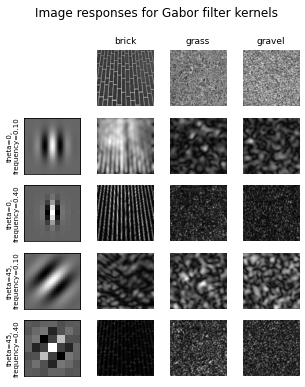

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel


def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i


# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)


shrink = (slice(0, None, 3), slice(0, None, 3))
brick = img_as_float(data.brick())[shrink]
grass = img_as_float(data.grass())[shrink]
gravel = img_as_float(data.gravel())[shrink]
image_names = ('brick', 'grass', 'gravel')
images = (brick, grass, gravel)

# prepare reference features
ref_feats = np.zeros((3, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats(brick, kernels)
ref_feats[1, :, :] = compute_feats(grass, kernels)
ref_feats[2, :, :] = compute_feats(gravel, kernels)

print('Rotated images matched against references using Gabor filter banks:')

print('original: brick, rotated: 30deg, match result: ', end='')
feats = compute_feats(ndi.rotate(brick, angle=190, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: brick, rotated: 70deg, match result: ', end='')
feats = compute_feats(ndi.rotate(brick, angle=70, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: grass, rotated: 145deg, match result: ', end='')
feats = compute_feats(ndi.rotate(grass, angle=145, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])


def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(5, 6))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel))
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()

### REFERENCES:
https://nbviewer.org/github/bicv/LogGabor/blob/master/LogGabor.ipynb

https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html
https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97